In [1]:
import pandas as pd
import os
from omegaconf import DictConfig 
from inference.read_report import ReportProcessor
from inference.compute_post_scores import ComputePostScore
import hydra
from hydra.utils import instantiate
from inference.visualization import DataVisualization
from inference.performance_statistics import *

In [25]:
def run_computation(cfg:DictConfig):
    processor = ReportProcessor(cfg)
    result_df = processor.read_metric_reports()
    InD_scenarios= load_scenario_types_from_csv('scenario_type_counts.csv')
    labeled_df = label_scenarios(result_df, InD_scenarios) 
    compute_postscore=ComputePostScore(labeled_df, cfg)
    energy_score = compute_postscore.get_energy_score()
    average_energy_score = compute_postscore.calculate_average_ood_score()
    visualizer = DataVisualization(figsize=(12, 8), alpha=0.6, grid=True)
    visualizer.draw_distribution(average_energy_score, score='ood_score_avg')

In [60]:
def run_computation(cfg:DictConfig):
    processor = ReportProcessor(cfg)
    result_df = processor.read_metric_reports()
    InD_scenarios= load_scenario_types_from_csv('scenario_type_counts.csv')
    labeled_df = label_scenarios(result_df, InD_scenarios) 
    # labeled_df =calculate_average_metric_score(labeled_df)
    # labeled_df = label_low_score(labeled_df)
    labeled_df = add_risk_label(labeled_df)
    compute_postscore=ComputePostScore(labeled_df, cfg)
    energy_score = compute_postscore.get_min_score()
    average_energy_score = compute_postscore.calculate_average_ood_score()
    visualizer = DataVisualization(figsize=(12, 8), alpha=0.6, grid=True)
    visualizer.draw_risk(average_energy_score, score='ood_score_avg')

In [65]:
CONFIG_PATH = 'inference/config'
CONFIG_NAME = 'runner_report'
hydra.core.global_hydra.GlobalHydra.instance().clear()
hydra.initialize(config_path=CONFIG_PATH)
# cfg = hydra.compose(config_name=CONFIG_NAME,overrides=['split=test','planner=planTF', 'job_name=open_loop_boxes'])
# cfg = hydra.compose(config_name=CONFIG_NAME,overrides=['job_name=open_loop_boxes'])
cfg = hydra.compose(config_name=CONFIG_NAME)
# cfg = hydra.compose(config_name=CONFIG_NAME,overrides=['job_name=closed_loop_reactive_agents'])

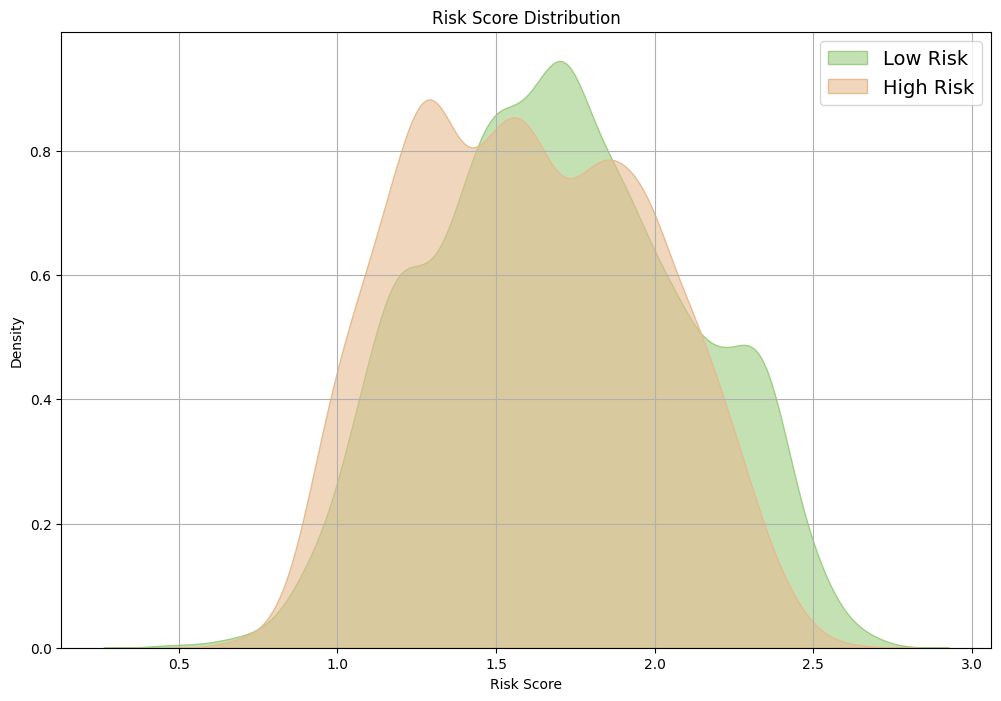

In [66]:
run_computation(cfg)

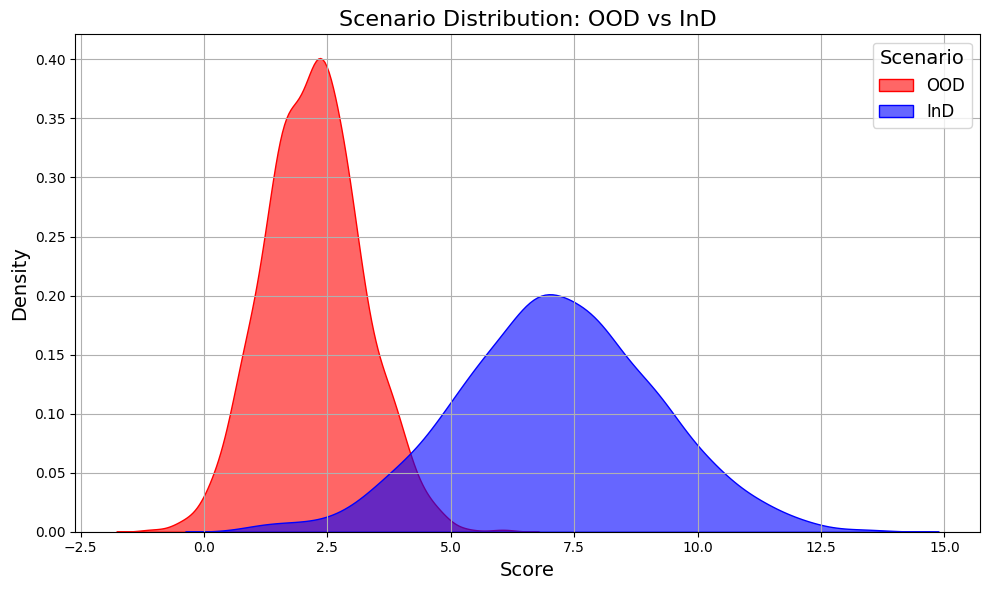

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 设置随机种子
np.random.seed(42)

# 生成示例数据
n_samples = 1000
ood_data = np.random.normal(loc=2.2, scale=1.0, size=n_samples)  # OOD 分布，均值为 3，标准差为 2.0
ind_data = np.random.normal(loc=7, scale=2.0, size=n_samples)  # InD 分布，均值为 6，标准差为 1.0

# 创建 DataFrame
df = pd.DataFrame({
    'score': np.concatenate([ood_data, ind_data]),
    'scenario': ['OOD'] * n_samples + ['InD'] * n_samples
})

# 绘制分布图
def draw_combined_distribution(df: pd.DataFrame, score: str) -> None:
    """
    绘制 OOD 和 InD 的分布在同一个图中。

    Parameters:
    - df (pd.DataFrame): 数据 DataFrame，包含 scores 和 scenario 列。
    - score (str): 分数列的名字。
    """
    plt.figure(figsize=(10, 6))

    # 绘制 OOD 分布
    sns.kdeplot(
        data=df[df['scenario'] == 'OOD'],
        x=score,
        fill=True,
        color='red',
        label='OOD',
        alpha=0.6
    )

    # 绘制 InD 分布
    sns.kdeplot(
        data=df[df['scenario'] == 'InD'],
        x=score,
        fill=True,
        color='blue',
        label='InD',
        alpha=0.6
    )

    # 添加标题和坐标轴标签
    plt.title('Scenario Distribution: OOD vs InD', fontsize=16)
    plt.xlabel('Score', fontsize=14)
    plt.ylabel('Density', fontsize=14)

    # 调整图例字体大小
    plt.legend(fontsize=12, title='Scenario', title_fontsize=14)

    # 添加网格
    plt.grid(True)

    # 显示图形
    plt.tight_layout()
    plt.show()

# 调用函数绘制图形
draw_combined_distribution(df, score='score')

In [ ]:
processor = ReportProcessor(cfg)
result_df = processor.read_metric_reports()

In [63]:
result_df=calculate_average_metric_score(result_df)
result_df=label_low_score(result_df)

In [59]:
result_df = add_risk_label(result_df)

ValueError: The following metrics are missing from the DataFrame: ['no_ego_at_fault_collisions', 'drivable_area_compliance', 'driving_direction_compliance', 'time_to_collision_within_bound', 'ego_progress_along_expert_route', 'ego_is_making_progress', 'ego_is_comfortable', 'speed_limit_compliance']

In [69]:
def get_scenario_type_counts(cache_dir: str) -> Dict[str, int]:
    scenario_type_counts = defaultdict(int)
    for log_name in os.listdir(cache_dir):
        log_name_path = os.path.join(cache_dir, log_name)
        if os.path.isdir(log_name_path):
            for scenario_type in os.listdir(log_name_path):
                scenario_type_path = os.path.join(log_name_path, scenario_type)
                if os.path.isdir(scenario_type_path):
                    token_count = len([
                        token for token in os.listdir(scenario_type_path)
                        if os.path.isdir(os.path.join(scenario_type_path, token))
                    ])
                    scenario_type_counts[scenario_type] += token_count
    return scenario_type_counts

In [70]:
scenario_type_counts= get_scenario_type_counts('exp/InD_train')

In [72]:
print(len(scenario_type_counts))

27


In [68]:
import os
import pandas as pd
import yaml
from collections import defaultdict
from ruamel.yaml import YAML
from typing import Any, Dict, List, Optional, Tuple